[View in Colaboratory](https://colab.research.google.com/github/jgarci135/Practicum-II/blob/master/Med_transfer_part_II.ipynb)

# Classification of Medical image files
##Company interest project
**Description of data:**
The images were obtained from video of medical procedures.  Due to the nature of the images and the current development within the company the images and the specific objective cannot be shared and is protected by an NDA.  There is an interest in specific features that occur at a specific time point.  The images collected are roughly collected from the same time point and have 5 different classifications present.  The classifications will be labeled simply 0,1,2,3,4+ or labeled with a PN prefix.  This is a limited data set as there is only 3732 samples present.  

**Objective:**
The objective of this project is to accurately identify the 5 classifications with good accuracy.  This data set is a good candidate for use with transfer learning.  There are not enough samples for a convolution neural network to properly learn the defining features and will benefit from the use of models that have been trained on much larger data sets.

##Main Issue with the Data Set
The first models built with the original data set composed of the 3732 images.  The results were sub optimal with an validation error rate of about 10% - 25%.  The biggest issue that can be seen is that there is no learning or measurable results from the validation accuracy.  The best model in use there was a discernible reduction of epochs in the training loss but not in the validation loss.   In this scenario there were added weights to help the imbalanced distribution of classes.

To ensure the model is working properly a confusion matrix was generated showed the only result predicted was a single case (see figure 1).  Multiple runs of the model and changing of the hyper-parameter did not change the results of only one class being predicted.  It is hypothesized that the distribution is causing the flat validation accuracy.  Other methods needed to be used to deal with the class imbalance. 


* The methods that are to be used will be getting more data through heavy augmentation of the images . 

* To help also help with resource management MobileNetV2 will be used for the majority of model building.

Confusion matrix, without normalization
[[  0   0   0  82   0]
 [  0   0   0  15   0]
 [  0   0   0 255   0]
 [  0   0   0  21   0]
 [  0   0   0   3   0]]


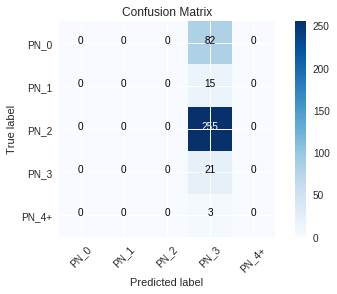

In [0]:
#figure 1
cm_plot_labels = ['PN_0','PN_1','PN_2','PN_3','PN_4+']
plot_confusion_matrix(cm, cm_plot_labels,title = 'Confusion Matrix')

##Set up to use Google Colab with Google Drive
The following cells contain how to set up a mounted drive to pull data from Google Drive. This is necessary as the VM instance of the Colab is reset at any point and all variables that are uploaded to the Colab will be erased. This helps then so that large image data sets do not need to be reloaded with each use.  Colab use is restricted to roughly 12 hours or GPU use and thus setting up the data set on a cloud is necessary.

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [0]:
#@title Default title text
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive


In [33]:
#check file directory to ensure that ocamlfuse is mounted
!df -h

Filesystem              Size  Used Avail Use% Mounted on
overlay                 359G  7.0G  334G   3% /
tmpfs                   6.4G     0  6.4G   0% /dev
tmpfs                   6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs                   6.4G  249M  6.2G   4% /opt/bin
/dev/sda1               365G   12G  354G   4% /etc/hosts
shm                      64M  4.0K   64M   1% /dev/shm
tmpfs                   6.4G     0  6.4G   0% /sys/firmware
google-drive-ocamlfuse   15G   11G  4.6G  70% /content/drive


**Install tqdm dependancy and update to Keras for access to MobileNetv2. **

Many of the files needed are preinstalled in Google Colab however these are not and will be needed for some of the operations.  Most importantly is the update to Keras.  The newest version is not preinstalled in Google Colab and thus does not have MobileNetv2 within its applications.

In [0]:
#Install tqdm for use with GoogleColab
!pip install tqdm

In [0]:
#Install most up to date Keras which is required to use mobilenetv2 
!pip install keras --upgrade

##Load Libraries

In [1]:
import sys
import keras
import tensorflow as tf
import numpy as np
import tqdm
import itertools
import argparse
import cv2
import os, shutil
import random
import h5py
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import math 
from IPython.display import Image
from os import path
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
from PIL import ImageOps
from collections import Counter
from glob import glob


from keras import backend as K

from keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping

from keras.optimizers import SGD, Adam, RMSprop

from keras.models import Model
from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, add, BatchNormalization

from keras.applications import MobileNet
from keras.applications import mobilenetv2
from keras.applications import VGG19
from keras.applications import imagenet_utils


from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from skimage import data, img_as_float
from skimage import exposure
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

config = tf.ConfigProto()
sess = tf.Session(config=config)
keras.backend.set_session(sess)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


In [71]:
#Check Nvidia GPU being used.
!nvidia-smi


Fri Aug 24 05:45:00 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    75W / 149W |  10891MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#Initialize directory paths and number of classes on LOCAL machine
data_dir = "pn_check_formated"
num_classes = len(glob(data_dir + "/*")) #Number comes from number of folders in directory
#num_classes = 5 # to be used with no folder structure dataset
train_dir = "pn_check_train_norm"
val_dir = "pn_check_val_norm"

In [0]:
#Initialize directory paths and number of classes COLAB
data_dir = os.path.join('../content/drive/practicum/pn_check_formated')
num_classes = len(glob(data_dir + "/*")) #Number comes from number of folders in directory

#File paths
train_dir = os.path.join('../content/drive/practicum/pn_check_train')
val_dir = os.path.join('../content/drive/practicum/pn_check_val')

In [0]:
# dimensions of the images.
img_width, img_height = 224, 224

# number of images
nb_train_samples = 10223 #number of images after augmentation
nb_validation_samples = 1330 #number of images after augmentation

#number of epochs to train model
epochs = 20

#batch size used by flow_from_diretory and predict_generator
batch_size = 200


##Image Processing and Preparation
Set up training and validation data splits.  The data does not have a file for labels but can be infered from the folder structure.  The file structure will also be important later on because data generators will be used to call the images.  Because the data set was small 90% was kept for training and 10% is to be used for validation. 

data/

    PN_check_train/
        0/
        1/
        2/
        3/
        4/
    PN_check_validation/
        0/
        1/
        2/
        3/
        4/
        
**Croping and augmenting images**

Images were also cropped and resized to 224x 224. The cropping of the images is important as there is little usable data contained in the outer edges of the images.  The resize will also help fit the application with a couple different pretrained model requirements which saves time. 

Most importantly since there were only a total of 3732 images total and there was an imbalance of class two and augmentation was used on all other classes to bring the totals number of images closer to each other.  

In [0]:
#Define image augmentation funtion.  Heavy image augmentation used.
#Code snippet retrived from (https://github.com/aleju/imgaug)
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

ia.seed(1)
def augment(x):
# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
    images = np.array(
        x
    )

    seq = iaa.Sequential([
        iaa.Fliplr(0.5), # horizontal flips
        iaa.Crop(percent=(0, 0.1)), # random crops
        # Small gaussian blur with random sigma between 0 and 0.5.
        # But we only blur about 50% of all images.
        iaa.Sometimes(0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        # Strengthen or weaken the contrast in each image.
        iaa.ContrastNormalization((0.75, 1.5)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )
    ], random_order=True) # apply augmenters in random order

    images_aug = seq.augment_image(images)
    return images_aug

### Image Processing and Preparation
To ensure all files were kept in correctly corresponding folders, so there was no confusion, this function was run on the original data set a number of times to create enough images to balance the classes.  

In [0]:
#split data into train and validation set
#data_dir = os.path.join('../content/drive/practicum/pn_check_formated')#CoLab
data_dir = os.path.join('/home/joshua/Downloads/pn_check_formated')#LocalSystem
num_classes = len(glob(data_dir + "/*"))

train_dir = "pn_check_train"
val_dir = "pn_check_val"

shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(val_dir, ignore_errors=True)
os.makedirs(train_dir)
os.makedirs(val_dir)

# Crop images 
tf_images = tf.placeholder(tf.uint8, shape=(None, None, None, 3))
unet_pb = "unet_s64_d2_ch32_2018-02-16.pb"
with tf.gfile.FastGFile(unet_pb, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    node_map = dict([(n.name, n) for n in graph_def.node])
    
    g_in = tf.import_graph_def(graph_def, 
                               name="keras_image_cropper",
                               input_map={"keras_image_cropper/image_input:0": tf_images},
                               return_elements=["keras_image_cropper/cropped_image:0", 
                                                "keras_image_cropper/crop_mask:0"])
    
def cropImage(image):
    cropped_images, crop_mask = sess.run(g_in, feed_dict={tf_images:np.expand_dims(image, axis=0)})
    return cropped_images[0]

for class_folder in tqdm.tqdm_notebook(glob(data_dir + "/*")):
    class_name = os.path.basename(class_folder)
    files = glob(class_folder + "/*.jpg")
    random.shuffle(files)
    split = int(len(files) * 0.9)
    os.makedirs(os.path.join(train_dir, class_name))
    os.makedirs(os.path.join(val_dir, class_name))
    for file in tqdm.tqdm_notebook(files[:split]):
        img = np.array(Image.open(file), np.float32) 
        crop_img = cropImage(img) * 255.0
        crop_img = crop_img.astype(np.byte)
        dst = np.zeros(shape=(224,224))       
        # Rotate images
        if img.shape[0] > 500: 
            crop_img = np.rot90(crop_img, -1)
            
        Image.fromarray(crop_img, "RGB").save(os.path.join(train_dir, class_name, os.path.basename(file)))
        image = cv2.imread((os.path.join(train_dir, class_name, os.path.basename(file))), cv2.IMREAD_COLOR)  # uint8 image
        #pass image to augment image function, then save augmented image
        image2 = augment(image)
        cv2.imwrite(os.path.join(train_dir,class_name, os.path.basename(file)),image2)
        
        
        
    for file in tqdm.tqdm_notebook(files[split:]):
        img = np.array(Image.open(file), np.float32)
        crop_img = cropImage(img) * 255.0
        crop_img = crop_img.astype(np.byte)
        dst = np.zeros(shape=(224,224))
        if img.shape[0] > 500:
            crop_img = np.rot90(crop_img, -1)
        
        Image.fromarray(crop_img, "RGB").save(os.path.join(val_dir, class_name, os.path.basename(file)))
        image = cv2.imread((os.path.join(val_dir, class_name, os.path.basename(file))), cv2.IMREAD_COLOR)  # uint8 image
        #pass image to augment image function, then save augmented image
        image2 = augment(image)
        cv2.imwrite(os.path.join(val_dir,class_name, os.path.basename(file)),image2)

##Exploritory Data Analysis

In [0]:
#Show a few images from each class with shape
for class_folder in glob(os.path.join(train_dir, "*")):
    plt.figure(figsize=(10,3))
    plt.suptitle(class_folder)
    for i, file in enumerate(glob(os.path.join(class_folder, "*.jpg"))):
        plt.subplot(1, 4, i+1)
        plt.imshow(Image.open(file))
        c0 = plt.imread(file) #read file path to an image, now c0 is a numpy image
        print(c0.shape)
        if i > 2:
            break
    plt.show()

## EDA: Histograms of Images
The images cannot be shown in this posting but their histograms are of importance and can be visualized. The histograms will be used to asses weather the image pixel intensity is balanced. This is a check that should occur because the training could suffer from the images not be balanced. The images pixile intensity has changed due to the augmentation and are no longer roughly the same however the intensity difference will not effect the model training in the same capacity as having an imbalanced data set.  The Histogram of the channels was also explored because the images are presented in RGB.  Both types of histograms show that the images are acceptable to be used for model buidling.

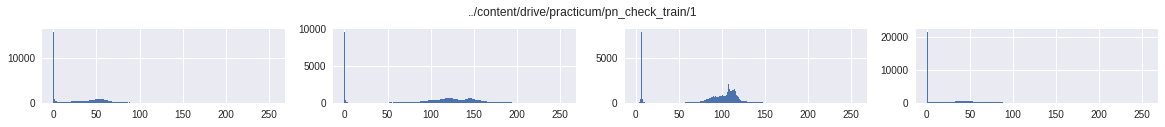

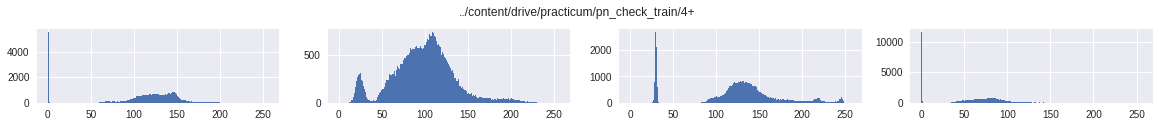

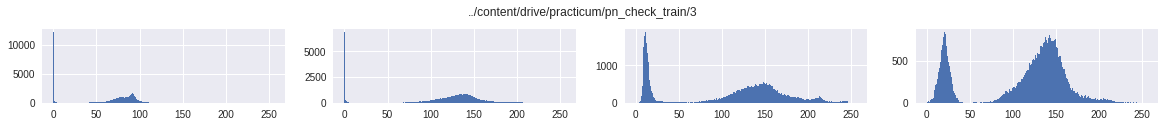

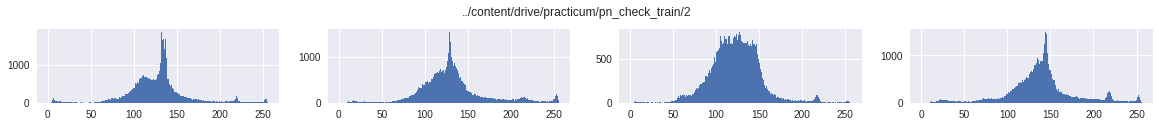

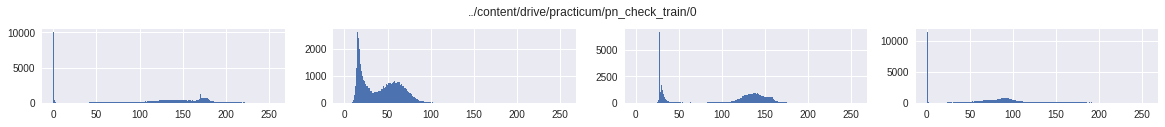

In [0]:

# Show a few histograms from each class
for class_folder in glob(os.path.join(train_dir, "*")):
    plt.figure(figsize=(20,3))
    plt.suptitle(class_folder)
    
    for i, file in enumerate(glob(os.path.join(class_folder, "*.jpg"))):
        plt.subplot(2, 4, i+1)
        img = cv2.imread(file,0)
        plt.hist(img.ravel(),256,[0,256]);
        if i > 2:
            break
    plt.show()   
    

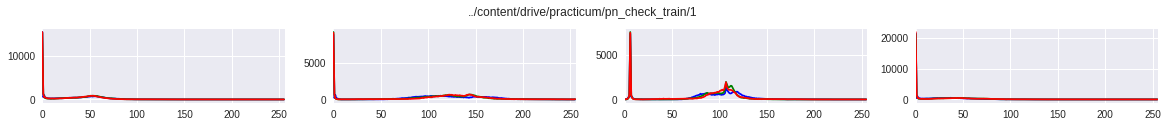

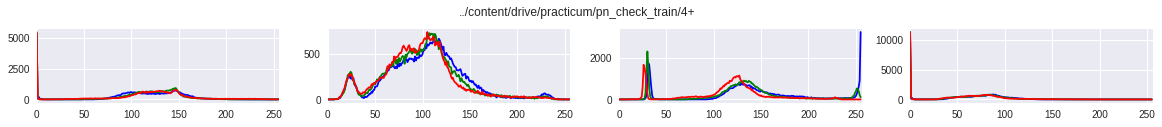

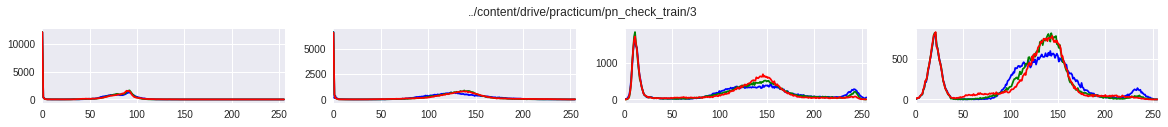

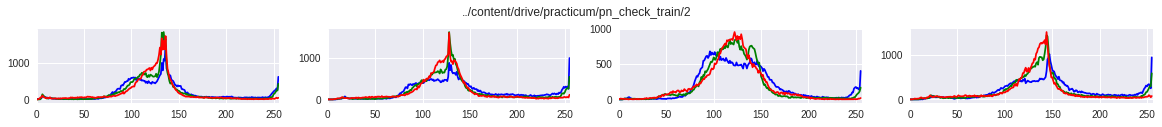

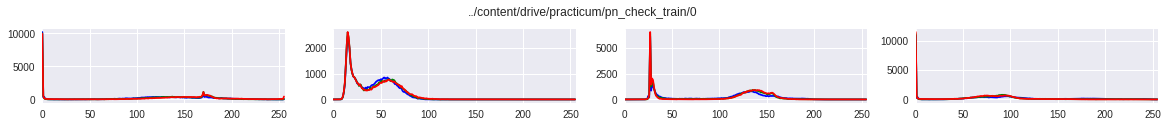

In [0]:
# Show a few RGB histograms from each class
for class_folder in glob(os.path.join(train_dir, "*")):
    plt.figure(figsize=(20,3))
    plt.suptitle(class_folder)
    color = ('b','g','r')
    
    for i, file in enumerate(glob(os.path.join(class_folder, "*.jpg"))):
        plt.subplot(2, 4, i+1)
        img = cv2.imread(file)
        
        for j,col in enumerate(color):
            histr = cv2.calcHist([img],[j],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        if i > 2:
             break
    plt.show()           

## EDA: Class Distributions
Before augmentation about 68 percent of the images belong to class 2 in both the training and validation set.  An unbalanced data set which will present a large problem in the training of any model.  

In the previous function when the images were cropped and split into training and validation images augmentation was also applied to the data sets over a number of iterations to create more samples for each class and balancing the data set.

Due to the extremely small number of images available from class 4, only a few iteration of augmentations were generated and the class was not completely balanced as the others were.  

The original class distributions were supplied to show the difference.

In [4]:
#Create train and validation batches for use with class indicies of folder contents
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenetv2.preprocess_input).flow_from_directory(
    train_dir, target_size=(224,224), batch_size=200, shuffle = True)
Valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenetv2.preprocess_input).flow_from_directory(
    val_dir, target_size=(224,224), batch_size=200, shuffle = True)  

Found 10223 images belonging to 5 classes.
Found 1330 images belonging to 5 classes.


In [0]:
#Import Class list and change to a pandas data frame
validation_class_distribution = pd.DataFrame(Valid_batches.classes)
train_class_distribution = pd.DataFrame(train_batches.classes)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Count')

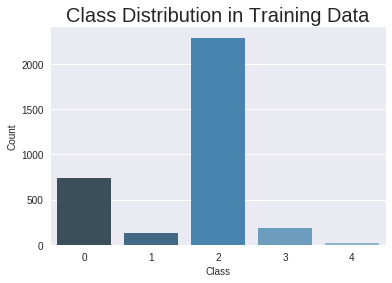

In [0]:
#Plot number of samples per class in the training set
sns.countplot(x=0, data=train_class_distribution, palette="Blues_d");
plt.title('Class Distribution in Training Data', fontsize = 20)
plt.xlabel('Class', fontsize = 10)
plt.ylabel('Count', fontsize = 10)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Count')

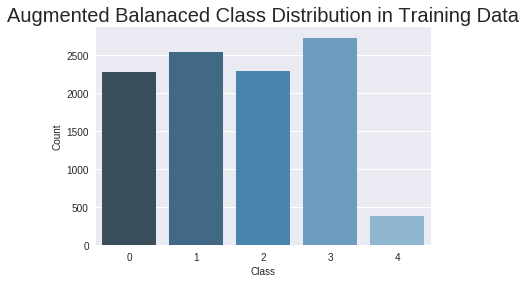

In [0]:
#Plot number of samples per class in the training set
sns.countplot(x=0, data=train_class_distribution, palette="Blues_d");
plt.title('Augmented Balanaced Class Distribution in Training Data', fontsize = 20)
plt.xlabel('Class', fontsize = 10)
plt.ylabel('Count', fontsize = 10)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Count')

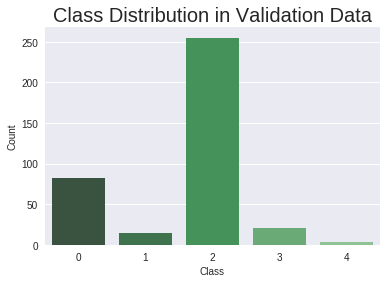

In [0]:
#Plot number of samples per class in the validation set
sns.countplot(x=0, data=validation_class_distribution, palette="Greens_d");
plt.title('Class Distribution in Validation Data', fontsize = 20)
plt.xlabel('Class', fontsize = 10)
plt.ylabel('Count', fontsize = 10)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Count')

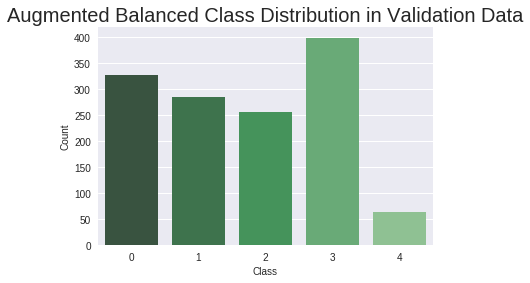

In [0]:
#Plot number of samples per class in the validation set
sns.countplot(x=0, data=validation_class_distribution, palette="Greens_d");
plt.title('Augmented Balanced Class Distribution in Validation Data', fontsize = 20)
plt.xlabel('Class', fontsize = 10)
plt.ylabel('Count', fontsize = 10)

##Definitions block for other functions to be used throughout the Notebook
* precesion metric 
* recall Metric
* Plotting Confusion Matrix

In [0]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

 

#Can be called in the metrics parameter
#model.compile(optimizer= "adam",
#              keras.losses.categorical_crossentropy,
#              metrics=[precision,recall])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
#define fuction to find weights of classes 
#Found defined function at https://github.com/keras-team/keras/issues/5116 by cbaziotis in the comments
def get_class_weights(y, smooth_factor=.1):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority / count) for cls, count in counter.items()}

##Create class class weights
Class weights will be calculated to further help with balancing the class distribution.  Class 4 has the fewest amount of images but is balanced with the use of weights added to the model and learning.

In [6]:
#Generate class weights to help balance class distribution
class_weights = get_class_weights(train_batches.classes) 
class_weights


{0: 1.1753424657534246,
 1: 1.066785079928952,
 2: 1.1725888324873097,
 3: 1.0,
 4: 4.591743119266055}

##Generating bottle neck features
To speed up some of the training and processing of the model, bottle neck features are generated and saved for future use.  Bottle neck features in this application were generated  with the entire model architecture.  It is possible to change if layers will update from the chosen model while extracting the bottleneck features. It is also possible to use a different layer of the model as the output to help specifiy earlier features from the model.  This at times can result in better accuracy.  

In this instance the entire MobileNetv2 was used to create the bottle neck features that will be used in the next steps.

In [41]:
#Create base model without the top or classifying layers. 
model = keras.applications.mobilenetv2.MobileNetV2(include_top=False, weights='imagenet') 

#Basic image generator to process images in data directory
datagen = ImageDataGenerator(rescale=1. / 255) 

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:310: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [0]:
#Create the bottleneck features for the training images
generator = datagen.flow_from_directory(  
    train_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
  
bottleneck_features_train = model.predict_generator(  
    generator, predict_size_train)  
   

In [0]:
np.save('/content/drive/practicum/bottleneck_features_train.npy', bottleneck_features_train)

In [0]:
#Create the bottleneck features for the Validation images
generator = datagen.flow_from_directory(  
    val_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
  
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
  
bottleneck_features_validation = model.predict_generator(  
    generator, predict_size_validation)  



Found 1330 images belonging to 5 classes.


In [0]:
#save bottelneck features to drive as numpy array
np.save('/content/drive/practicum/bottleneck_features_validation.npy', bottleneck_features_validation) 

###Load bottle neck features
The bottle neck features can be large files.  In this case they were saved as numpy array files are are about 3-4 gb in size.  The loading of these files however is faster then re-running the part of the algorithm each time a model is run.

In [7]:
#Load bottleneck features for the training images
from keras.utils.np_utils import to_categorical
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
        train_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,  
        class_mode='categorical',  
        shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features 
train_data = np.load('/content/drive/practicum/bottleneck_features_train.npy')  
   
# aquire the class labels for the training data in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)  

Found 10223 images belonging to 5 classes.


In [8]:
#Load bottleneck features for validation images
generator_top = datagen_top.flow_from_directory(  
        val_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,  
        class_mode=None,  
        shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
  
validation_data = np.load('/content/drive/practicum/bottleneck_features_validation.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 1330 images belonging to 5 classes.


##Train Top Model
Since the bottle neck features have been loaded all that is left is the final layers of a model to be run which will do the classification of the processed images.  The top of the model will have a fully connected layer and a classification layer at a minimum.  In the case of this model is also has Dropout and Batch Normalization.  

In [24]:
#Train top of model
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(2056))
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(BatchNormalization()) 
model.add(Dense(num_classes))
model.add(Activation('softmax'))
   
#metrics =  ['acc', recall, precision] used to collect differing metrics so evaluate model.
#model.compile(
#              Adam(lr=0.0001), 
#              keras.losses.categorical_crossentropy,metrics=['acc', recall, precision]) 

#model.compile(
#              RMSprop(lr=0.00001, rho=0.9, epsilon=None, decay=1.0), 
#              keras.losses.categorical_crossentropy,metrics=['acc', recall, precision])

model.compile(
             SGD(lr=.00001, momentum=1.0), 
              keras.losses.categorical_crossentropy,metrics=['acc', recall, precision])

history = model.fit(train_data, train_labels,  
         epochs=12,  
         batch_size=64,  
         class_weight = class_weights,
         validation_data=(validation_data, validation_labels))  
    
#model.save('/content/drive/practicum/MedMobilev2.h5')   


Train on 10223 samples, validate on 1330 samples
Epoch 1/12
10223/10223 [==============================] - 17s 2ms/step - loss: 2.2062 - acc: 0.3948 - recall: 0.3247 - precision: 0.4336 - val_loss: 1.5524 - val_acc: 0.5105 - val_recall: 0.4368 - val_precision: 0.5281
Epoch 2/12
10223/10223 [==============================] - 14s 1ms/step - loss: 1.5883 - acc: 0.5507 - recall: 0.4936 - precision: 0.5857 - val_loss: 1.2255 - val_acc: 0.5759 - val_recall: 0.5053 - val_precision: 0.6046
Epoch 3/12
10223/10223 [==============================] - 14s 1ms/step - loss: 1.2322 - acc: 0.6138 - recall: 0.5486 - precision: 0.6592 - val_loss: 1.1008 - val_acc: 0.6263 - val_recall: 0.5564 - val_precision: 0.6518
Epoch 4/12
10223/10223 [==============================] - 14s 1ms/step - loss: 1.1000 - acc: 0.6548 - recall: 0.5861 - precision: 0.7029 - val_loss: 1.0143 - val_acc: 0.6391 - val_recall: 0.5699 - val_precision: 0.6686
Epoch 5/12
10223/10223 [==============================] - 14s 1ms/step - lo

###Plot of Results
The plot shown here is a plot by SGD and by examining the plot, the fit of the validation data is better than the other optimizer and generalized  fairly well.  With such a low learning rate the loss of both training and validation are slow as are the accuracy rate.  The final accuracy is 61% over the course of 50 epochs. 

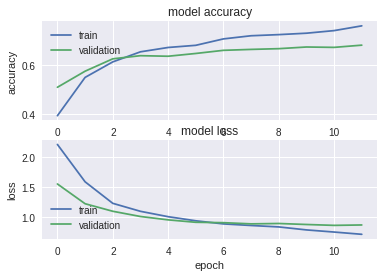

In [25]:
#Plot accuracy
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
  
# summarize history for loss  
  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='lower left')  
plt.show()  

In [0]:
model.save_weights('/content/drive/practicum/top_model_weights_path')

##Evaluation of Model Performance
A confusion matrix is used to evaluate the performance of the model.  The accuracy is an indicator and has not risen above about 72% for the validation accuracy.  As seen here compared to the original starting point of the model the additional augmented samples have balanced the data set enough that the model has become effective in making useful predictions. The prediction accuracy of the validation set is no longer in a single class and have many correctly classified images.  The diagonal of the matrix indicated many have been correctly classified however there is still room for improvement as there are a high number of images that are not correctly classified.

A normalized confusion matrix gives the percentage of correctly classified images per class.

Confusion matrix, without normalization
[[203  45  39  36   5]
 [ 35 155  15  73   7]
 [ 10   1 243   0   1]
 [ 26  69  20 273  11]
 [  1  10   3  16  33]]
Normalized confusion matrix
[[0.61890244 0.13719512 0.11890244 0.1097561  0.0152439 ]
 [0.12280702 0.54385965 0.05263158 0.25614035 0.0245614 ]
 [0.03921569 0.00392157 0.95294118 0.         0.00392157]
 [0.06516291 0.17293233 0.05012531 0.68421053 0.02756892]
 [0.01587302 0.15873016 0.04761905 0.25396825 0.52380952]]


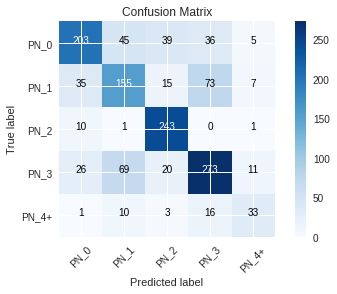

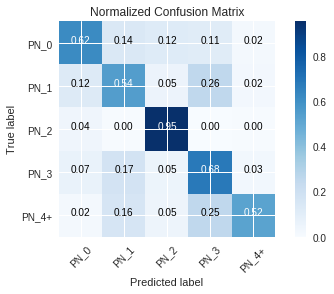

In [26]:
#Confustion matrix
 
#To create the predicition model using the validation samples. NOTE: steps must be the sample divided by the number of batch size. In this case it was samples size 1330 and batch size =200.
#This is needed to create a correct confusion matrix.

#predictions = model.predict_classes(validation_data) #this line can be used inplace of the model.predict which needs batch_size.
predictions = model.predict(validation_data, batch_size = batch_size)

#Prediction array
predictions
#Change prediction array into integers
predictions.argmax(axis = 1)

#labels
valid_labels = Valid_batches.classes
valid_labels

#The confusion matrix is made from the labels provided and passed to the argument. 
#arg max is selected to take the maximum value of the prediction.
cm = confusion_matrix(valid_labels, predictions.argmax(axis = 1))


#Plot_confusion_matrix is defined within definition block and was retireved from SciKitLearn 
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#labels for matrix. alternativly can use "classes=Valid_batches.class_indices" for folder names instead creating labels
cm_plot_labels = ['PN_0','PN_1','PN_2','PN_3','PN_4+']

plt.figure()
plot_confusion_matrix(cm, cm_plot_labels,
                      title = 'Confusion Matrix')

plt.figure()
plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                      title='Normalized Confusion Matrix')

plt.show()



## Summary

Results from MobilenetV2 show better results compared to the original model discussed in part 1 of the project.  This is due to better management and processing of the samples but more importantly the balanced data classes.  All models show some form of learning is completed but there seems to be a limit to the learning accuracy of about 72%.  Many methods were used to try increase the accuracy of the model but none had the desired effect.  

The defined problem and objective was re-evaluated because the accuracy of the model was no longer improving.  Different metrics were examined to access the effectiveness of the model such as recall and precision.  Neither of these metrics helped better the evaluation of the model.  During this process it became clear by examining the normalized confusion matrix that there was an accuracy of correctly classifying class 2 at the high rate of 96%. Only 10 images were being miss classified in the validation set.  Instead of trying to classify all classes correctly the objective shifted to correctly classifying the most important target.  Class 0, 1, 3, and 4 can all be grouped together as non viable.  

The model has accomplished its purpose.



In [80]:
#Current versions
keras.__version__
print (sys.version)
print(tf.__version__)

3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
1.10.0


#Resources
ImageNet: VGGNet, ResNet, Inception, and Xception with Keras

https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/

Nearly every page in Keras

https://keras.io/applications/

MobileNetV2

https://github.com/xiaochus/MobileNetV2/blob/master/train.py

Class weights function

https://github.com/keras-team/keras/issues/5116

Heavy image augmentation

https://github.com/aleju/imgaug

Plots

https://seaborn.pydata.org/tutorial/categorical.html

Imbalanced Data

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

MobileNet and confusion matrix

http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

https://www.youtube.com/channel/UC4UJ26WkceqONNF5S26OiVw

Transfer Learning

https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

VGG16 methods

https://www.kaggle.com/fujisan/use-keras-pre-trained-vgg16-acc-98

Histograms

https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_begins/py_histogram_begins.html

Image Normilization

https://stackoverflow.com/questions/38025838/normalizing-images-in-opencv

Learning rates

https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

